In [1]:
import json
from networkx.readwrite import json_graph

def read_graph_from_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    return json_graph.adjacency_graph(data) 

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
#filepath = 'districting-data\\'
filename = 'MT_county.json'

G = read_graph_from_json( filename )

In [3]:
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [4]:
# Let's impose a 2% population deviation (+/-1%)
deviation = 0.01

import math
k = 2          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

#L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
#U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
L = math.floor( total_population / k ) #one person deviation
U = math.ceil( total_population / k )  #one person deviation
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 542112 and U = 542113 and k = 2


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

Set parameter Username
Set parameter LicenseID to value 2628084
Academic license - for non-commercial use only - expires 2026-02-25


In [6]:
m.reset()

Discarded solution information


In [7]:
# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

In [8]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [9]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))

m.update()

In [10]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY )

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )

In [11]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [12]:
# solve IP model
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 20.6.0 20G165)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 644 rows, 638 columns and 2578 nonzeros
Model fingerprint: 0x045015d8
Variable types: 276 continuous, 362 integer (362 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Presolve removed 58 rows and 56 columns
Presolve time: 0.00s
Presolved: 586 rows, 582 columns, 2354 nonzeros
Variable types: 276 continuous, 306 integer (306 binary)

Root relaxation: objective 0.000000e+00, 155 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   60          -    0.00000      -     -    0s
     0     0    0.65357   

In [13]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 24.0
District 0 has population 542112 and contains counties ['Broadwater', 'Big Horn', 'Custer', 'Richland', 'Wibaux', 'Toole', 'Blaine', 'Judith Basin', 'Roosevelt', 'Fallon', 'McCone', 'Teton', 'Dawson', 'Powder River', 'Glacier', 'Hill', 'Treasure', 'Yellowstone', 'Wheatland', 'Valley', 'Petroleum', 'Phillips', 'Sheridan', 'Daniels', 'Prairie', 'Musselshell', 'Chouteau', 'Meagher', 'Rosebud', 'Sweet Grass', 'Pondera', 'Garfield', 'Carter', 'Liberty', 'Cascade', 'Flathead', 'Fergus']

District 1 has population 542113 and contains counties ['Sanders', 'Lincoln', 'Granite', 'Golden Valley', 'Carbon', 'Powell', 'Park', 'Stillwater', 'Lake', 'Mineral', 'Jefferson', 'Deer Lodge', 'Ravalli', 'Missoula', 'Madison', 'Beaverhead', 'Lewis and Clark', 'Gallatin', 'Silver Bow']



In [14]:
# To solve the MIP faster, let's fix some district roots:

#r[6,0].LB = 1  # Fix Oklahoma County as root of district 0
#r[34,1].LB = 1 # Fix Tulsa County as root of district 1
#r[8,2].LB = 1  # Fix Comanche County as root of district 2

#m.reset()      # Force Gurobi to start solving 'from scratch'
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 20.6.0 20G165)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 644 rows, 638 columns and 2578 nonzeros
Model fingerprint: 0x045015d8
Variable types: 276 continuous, 362 integer (362 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+05]
Presolved: 586 rows, 582 columns, 2354 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 2
  Flow cover: 14

Explored 400088 nodes (15107009 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 24 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.400000000000e+01, best bound 2.400000000000e+01, gap 0.0000%


In [15]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 24.0
District 0 has population 542112 and contains counties ['Broadwater', 'Big Horn', 'Custer', 'Richland', 'Wibaux', 'Toole', 'Blaine', 'Judith Basin', 'Roosevelt', 'Fallon', 'McCone', 'Teton', 'Dawson', 'Powder River', 'Glacier', 'Hill', 'Treasure', 'Yellowstone', 'Wheatland', 'Valley', 'Petroleum', 'Phillips', 'Sheridan', 'Daniels', 'Prairie', 'Musselshell', 'Chouteau', 'Meagher', 'Rosebud', 'Sweet Grass', 'Pondera', 'Garfield', 'Carter', 'Liberty', 'Cascade', 'Flathead', 'Fergus']

District 1 has population 542113 and contains counties ['Sanders', 'Lincoln', 'Granite', 'Golden Valley', 'Carbon', 'Powell', 'Park', 'Stillwater', 'Lake', 'Mineral', 'Jefferson', 'Deer Lodge', 'Ravalli', 'Missoula', 'Madison', 'Beaverhead', 'Lewis and Clark', 'Gallatin', 'Silver Bow']



In [16]:
# Let's draw it on a map
import geopandas as gpd

In [17]:
# Read Oklahoma county shapefile from "OK_county.shp"
#filepath = 'districting-data\\'
filename = 'MT_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filename )

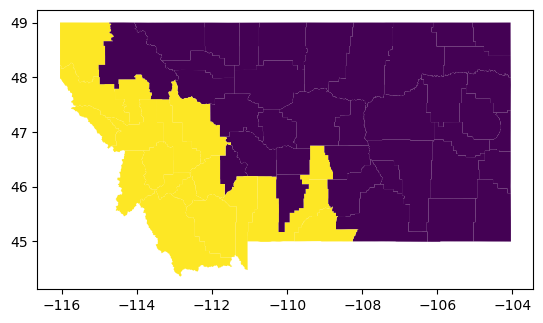

In [18]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()